In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [4]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
from transformations import func_inv_jac, func_labels, label_dict

# Load as module

In [33]:
from TracerFit import mwfit, int_idx
model = mwfit(sf_bool=False, perr_bool=False)

In [34]:
model.load('/data/asfe2/Projects/mwtrace_data/mockmodel/class_testsave.h')

# Load data

In [35]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model.sample['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])

In [36]:
model._generate_fid_pars()

In [37]:
model.sample=sample

# Plot results

In [38]:
true_params_f = model.transform_params(model.get_true_params(true_pars))

In [39]:
model.sample

{'M': array([9.94548413, 8.66725102, 6.49854526, ..., 9.39372056, 6.61712389,
        9.97796079]),
 'cmpt': array([0, 0, 0, ..., 2, 2, 2]),
 'l': array([4.52023236, 5.59570181, 0.94286162, ..., 6.03643905, 2.59110118,
        2.24767077]),
 'm': array([22.35510168, 20.66061074, 18.82619035, ..., 24.06022306,
        21.6857307 , 25.07229157]),
 'm_err': array([0.14924223, 0.85957193, 0.70051079, ..., 0.20779168, 0.58663772,
        0.39527869]),
 'm_obs': array([22.51208409, 19.4295744 , 19.06851472, ..., 24.3015643 ,
        20.63167328, 25.41820448]),
 'parallax_error': array([0.21580455, 0.35807379, 0.34877986, ..., 0.08521639, 0.86329818,
        0.54260755]),
 'parallax_obs': array([ 0.17366025,  0.74154758, -0.37266474, ..., -0.09941144,
         1.04244236, -0.6535669 ]),
 's': array([ 3.03335689,  2.50421691,  2.92098293, ...,  8.57631059,
        10.32099008, 10.44398299]),
 'sinb': array([0.91404324, 0.86615762, 0.96723606, ..., 0.90273667, 0.96508363,
        0.9287926 ]),


(1.0, 10000)

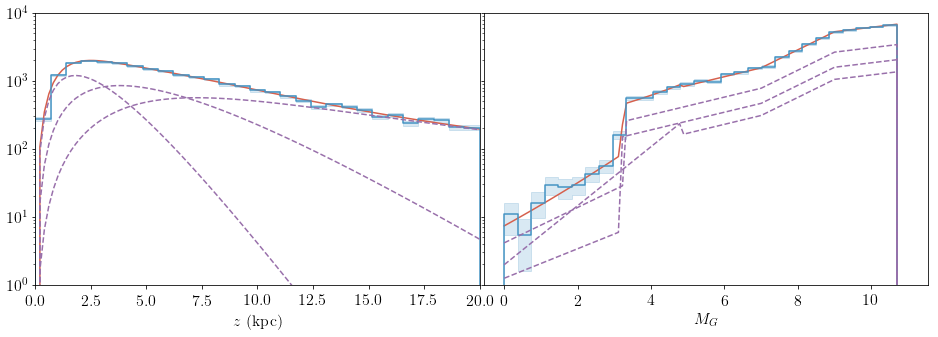

In [13]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

parameters = true_params_f.copy()

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

axes[0].plot(z_arr, dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(1.,10000)

(1.0, 10000)

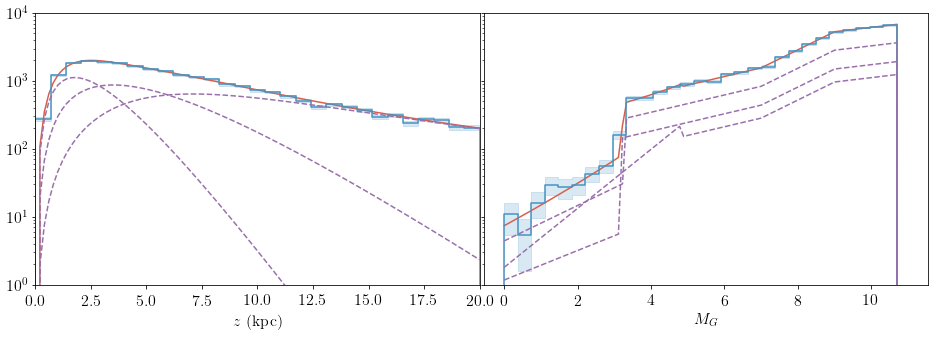

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

parameters = model.optimize_results['x']['full_ncg_parallel'][1].copy()

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

axes[0].plot(z_arr, dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(1.,10000)

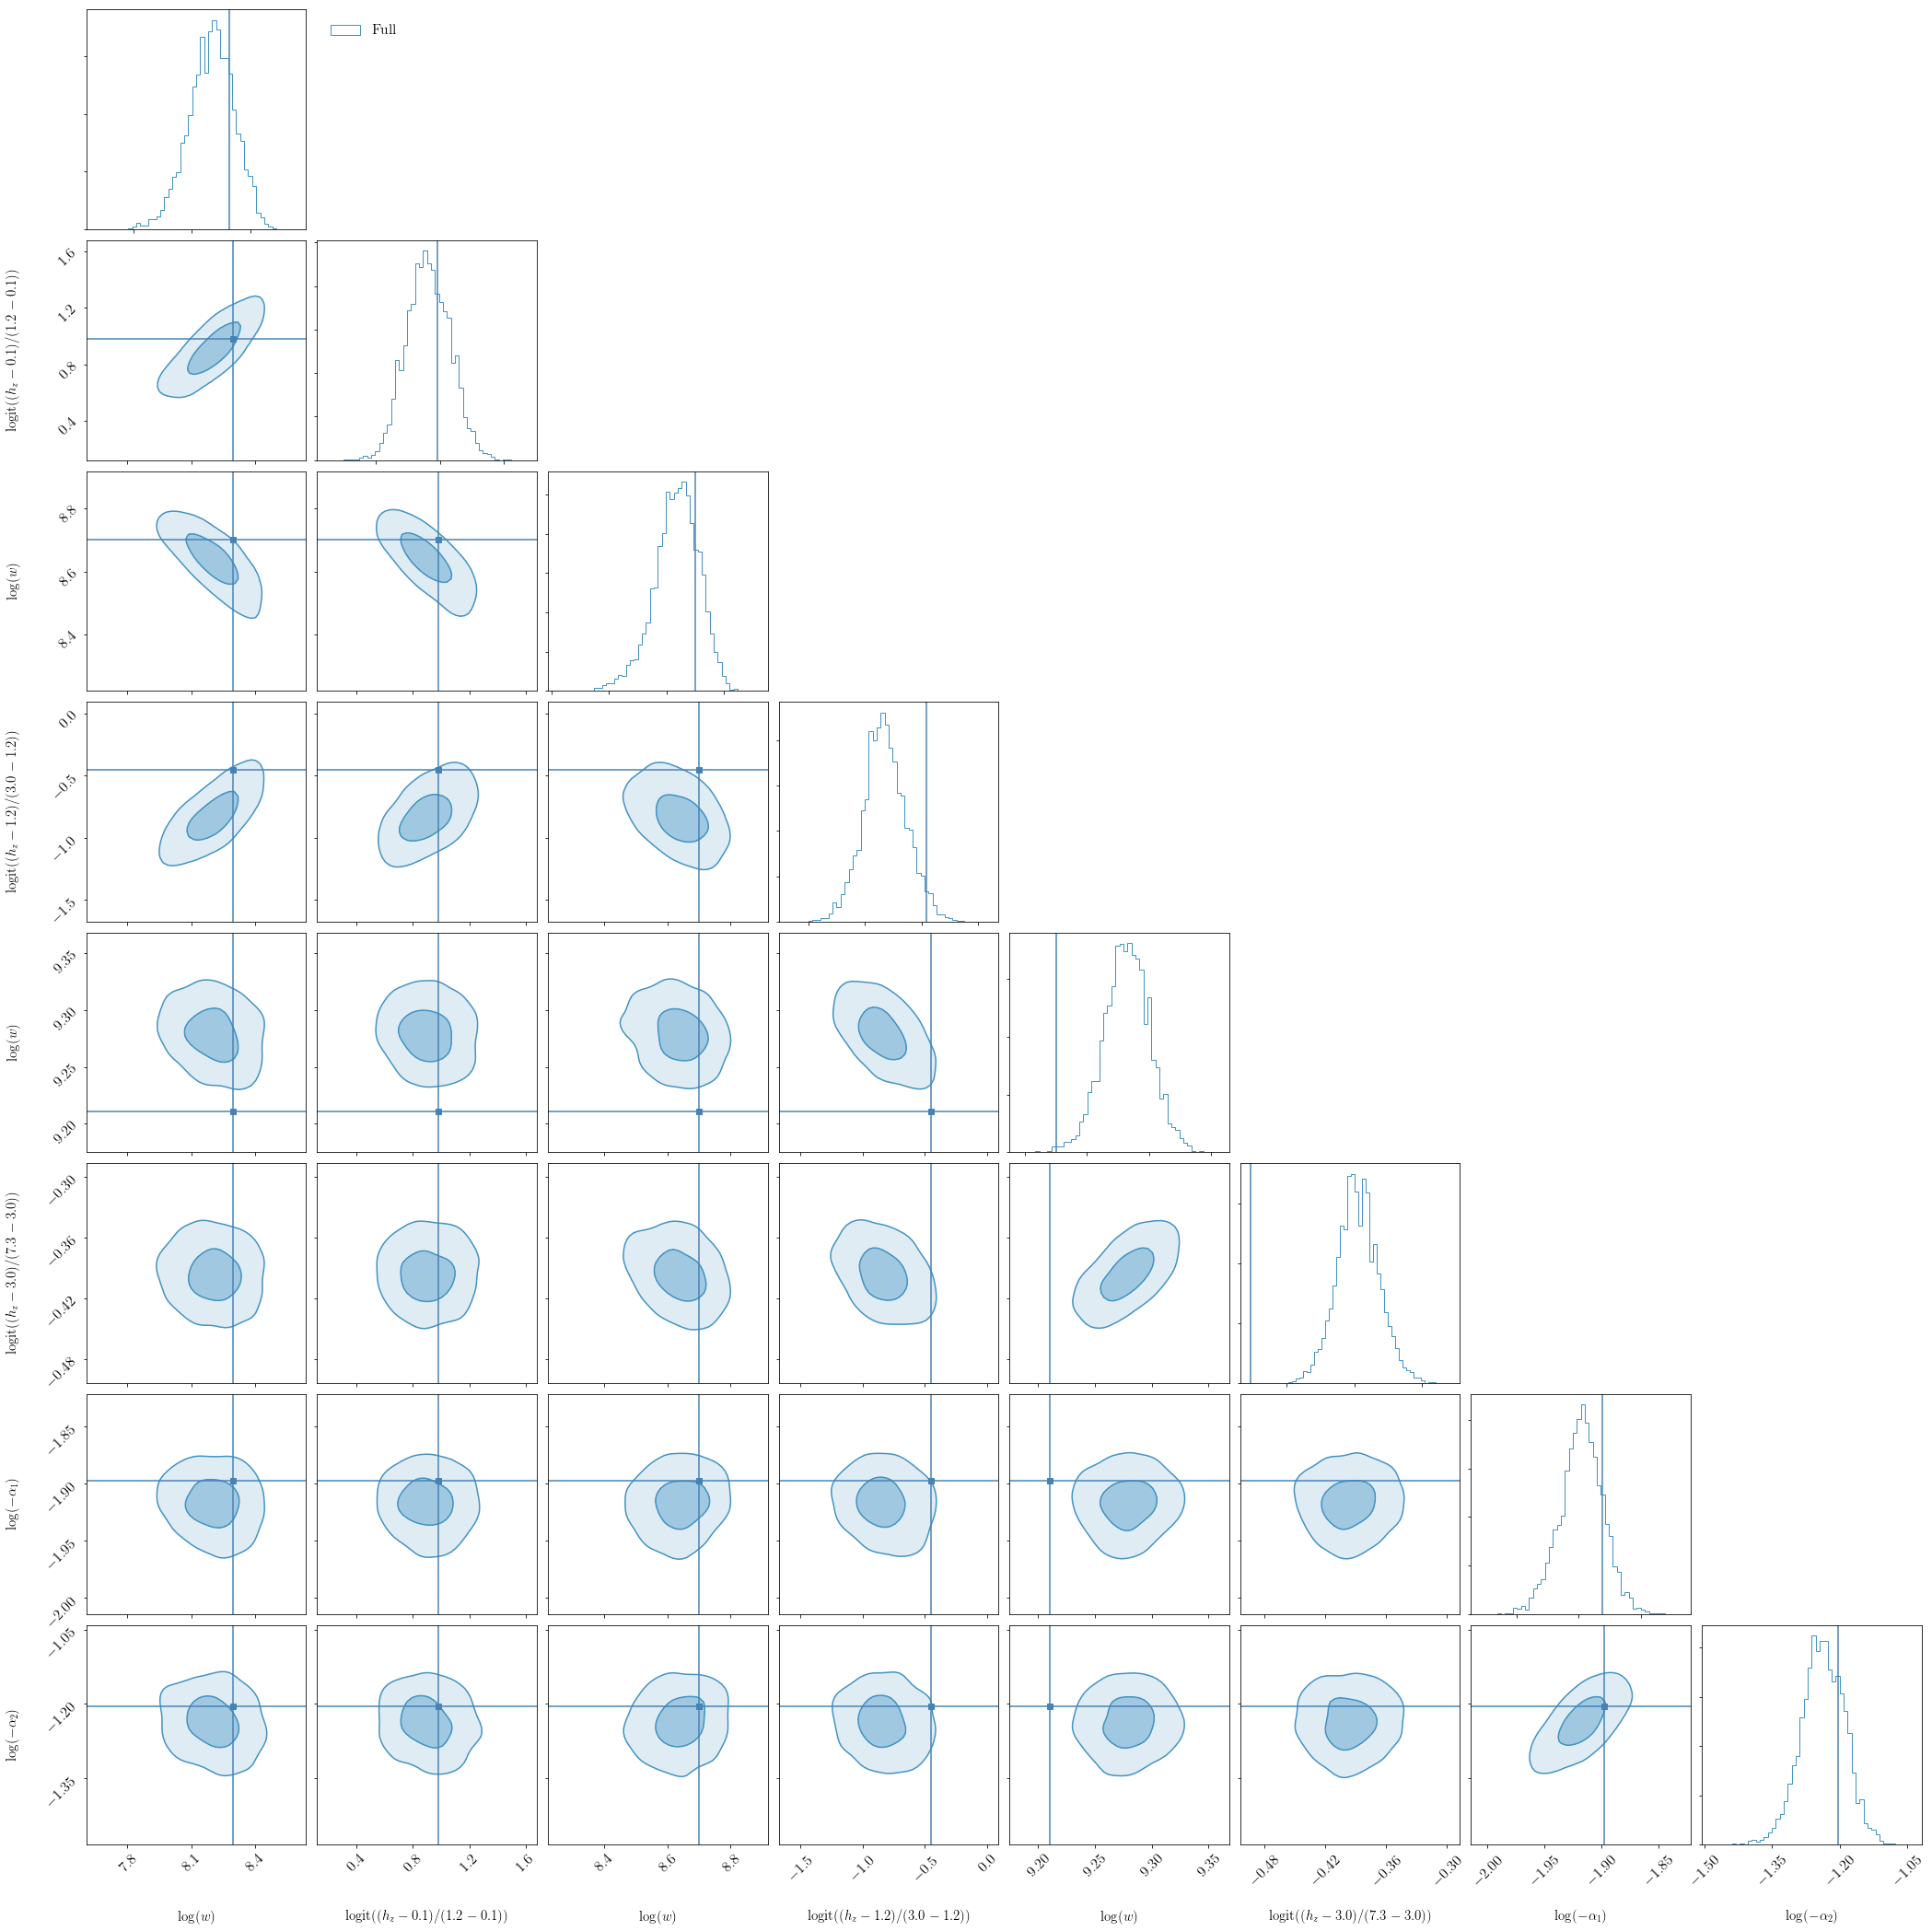

In [44]:
index = [r'Full']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(30,30))
plotting.layered_corners([model.mcmc_results['chain']['full_1']], index=index, 
                         truths=true_params_f, labels=model.get_labels(),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)], fig=fig, ax=axes)

# Load in model fits

In [5]:
def load_hdf5_recurrent(path, hf):
    output={}

    for key in hf[path].keys():
        if isinstance(hf[os.path.join(path,key)], h5py._hl.group.Group): 
            output[int_idx(key)] = load_hdf5_recurrent(os.path.join(path,key), hf)
        else:
            output[int_idx(key)] = hf[os.path.join(path,key)][...]
            
    return output

def int_idx(i):
    if i in np.arange(10).astype(str):
        return int(i)
    else: return i

In [6]:
data = {}
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/fits_allcmpt_ncg.h'
with h5py.File(filename, 'r') as hf:
    for key in hf.keys():
        if isinstance(hf[key], h5py._hl.group.Group): 
            data[int_idx(key)] = load_hdf5_recurrent(key, hf)
        else: data[int_idx(key)] = hf[key][...]
            
for cmpt in data['param_trans'].keys():
    for par in data['param_trans'][cmpt].keys():
        data['param_trans'][cmpt][par] = data['param_trans'][cmpt][par].astype('U20').tolist()
        for i in [1,2,3,4]:
            data['param_trans'][cmpt][par][i] = float(data['param_trans'][cmpt][par][i])
for cmpt in data['free_pars'].keys():
    data['free_pars'][cmpt] = data['free_pars'][cmpt].astype('U20')

In [7]:
data.keys()

dict_keys(['fixed_pars', 'param_trans', 'lnprob', 'source_id', 'true_pars', 'free_pars', 'chain'])

# Load data

In [115]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], data['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[str(j)]['w']*=len(sample['source_id'])

In [117]:
true_params_f=[];
true_params=[]; 
for j in range(fid_pars['ncomponents']):
    for par in fid_pars['free_pars'][j]:
        true_params_f   += [fid_pars['functions_inv'][j][par](true_pars[str(j)][par]),]
        true_params += [true_pars[str(j)][par],]
for par in fid_pars['free_pars']['shd']:
    true_params_f += [fid_pars['functions_inv']['shd'][par](true_pars[par]),]
    true_params += [true_pars[par],]
true_params_f=np.array(true_params_f)
true_params=np.array(true_params)
true_params, true_params_f

(array([ 2.0e+02,  9.0e-01,  3.0e+02,  1.9e+00,  5.0e+02,  4.6e+00,
        -1.5e-01, -3.0e-01]),
 array([ 5.29831737,  0.98082925,  5.70378247, -0.45198512,  6.2146081 ,
        -0.52324814, -1.89711998, -1.2039728 ]))

In [139]:
labels=[]; params_i = 0
for cmpt in np.arange(3).tolist()+['shd',]:
    for par in data['free_pars'][cmpt]:
        labels+=[func_labels[data['param_trans'][cmpt][par][0]](label_dict[par], *data['param_trans'][cmpt][par][1:3]),]
        params_i += 1;

# Rebuild fid_pars

In [110]:
fid_pars={'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']), 'R0':true_pars['R0'],
            'w':True, 'components':['disk','disk','halo'], 'ncomponents':3,
         'free_pars':data['free_pars'], 'fixed_pars':data['fixed_pars']}

In [112]:
fid_pars['functions']={}; fid_pars['functions_inv']={}; fid_pars['jacobians']={}; bounds=[]
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['functions'][cmpt]={}; fid_pars['functions_inv'][cmpt]={}; fid_pars['jacobians'][cmpt]={}
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['functions'][cmpt][par], \
        fid_pars['functions_inv'][cmpt][par], \
        fid_pars['jacobians'][cmpt][par]=func_inv_jac[data['param_trans'][cmpt][par][0]](*data['param_trans'][cmpt][par][1:3])
        bounds.append([data['param_trans'][cmpt][par][3], data['param_trans'][cmpt][par][4]])
        params_i += 1;
bounds = np.array(bounds).T

# Plot results

(0.1, 1000)

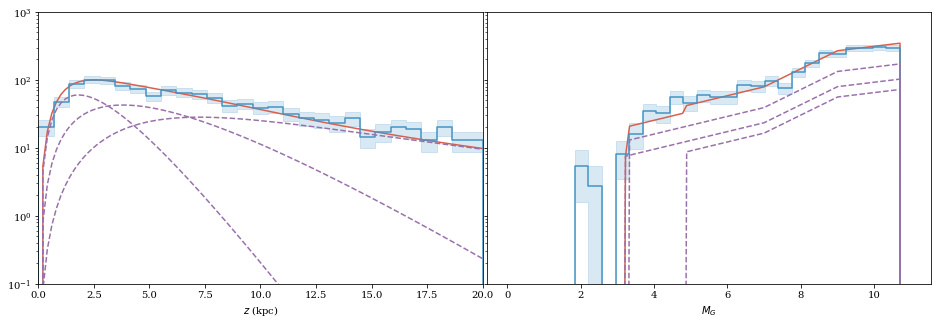

In [126]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['s']*sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(0.1,1000)

In [129]:
data['chain'].keys()#['full_perr']

dict_keys(['full_perr_ncg', 'full_perr', 'prior'])

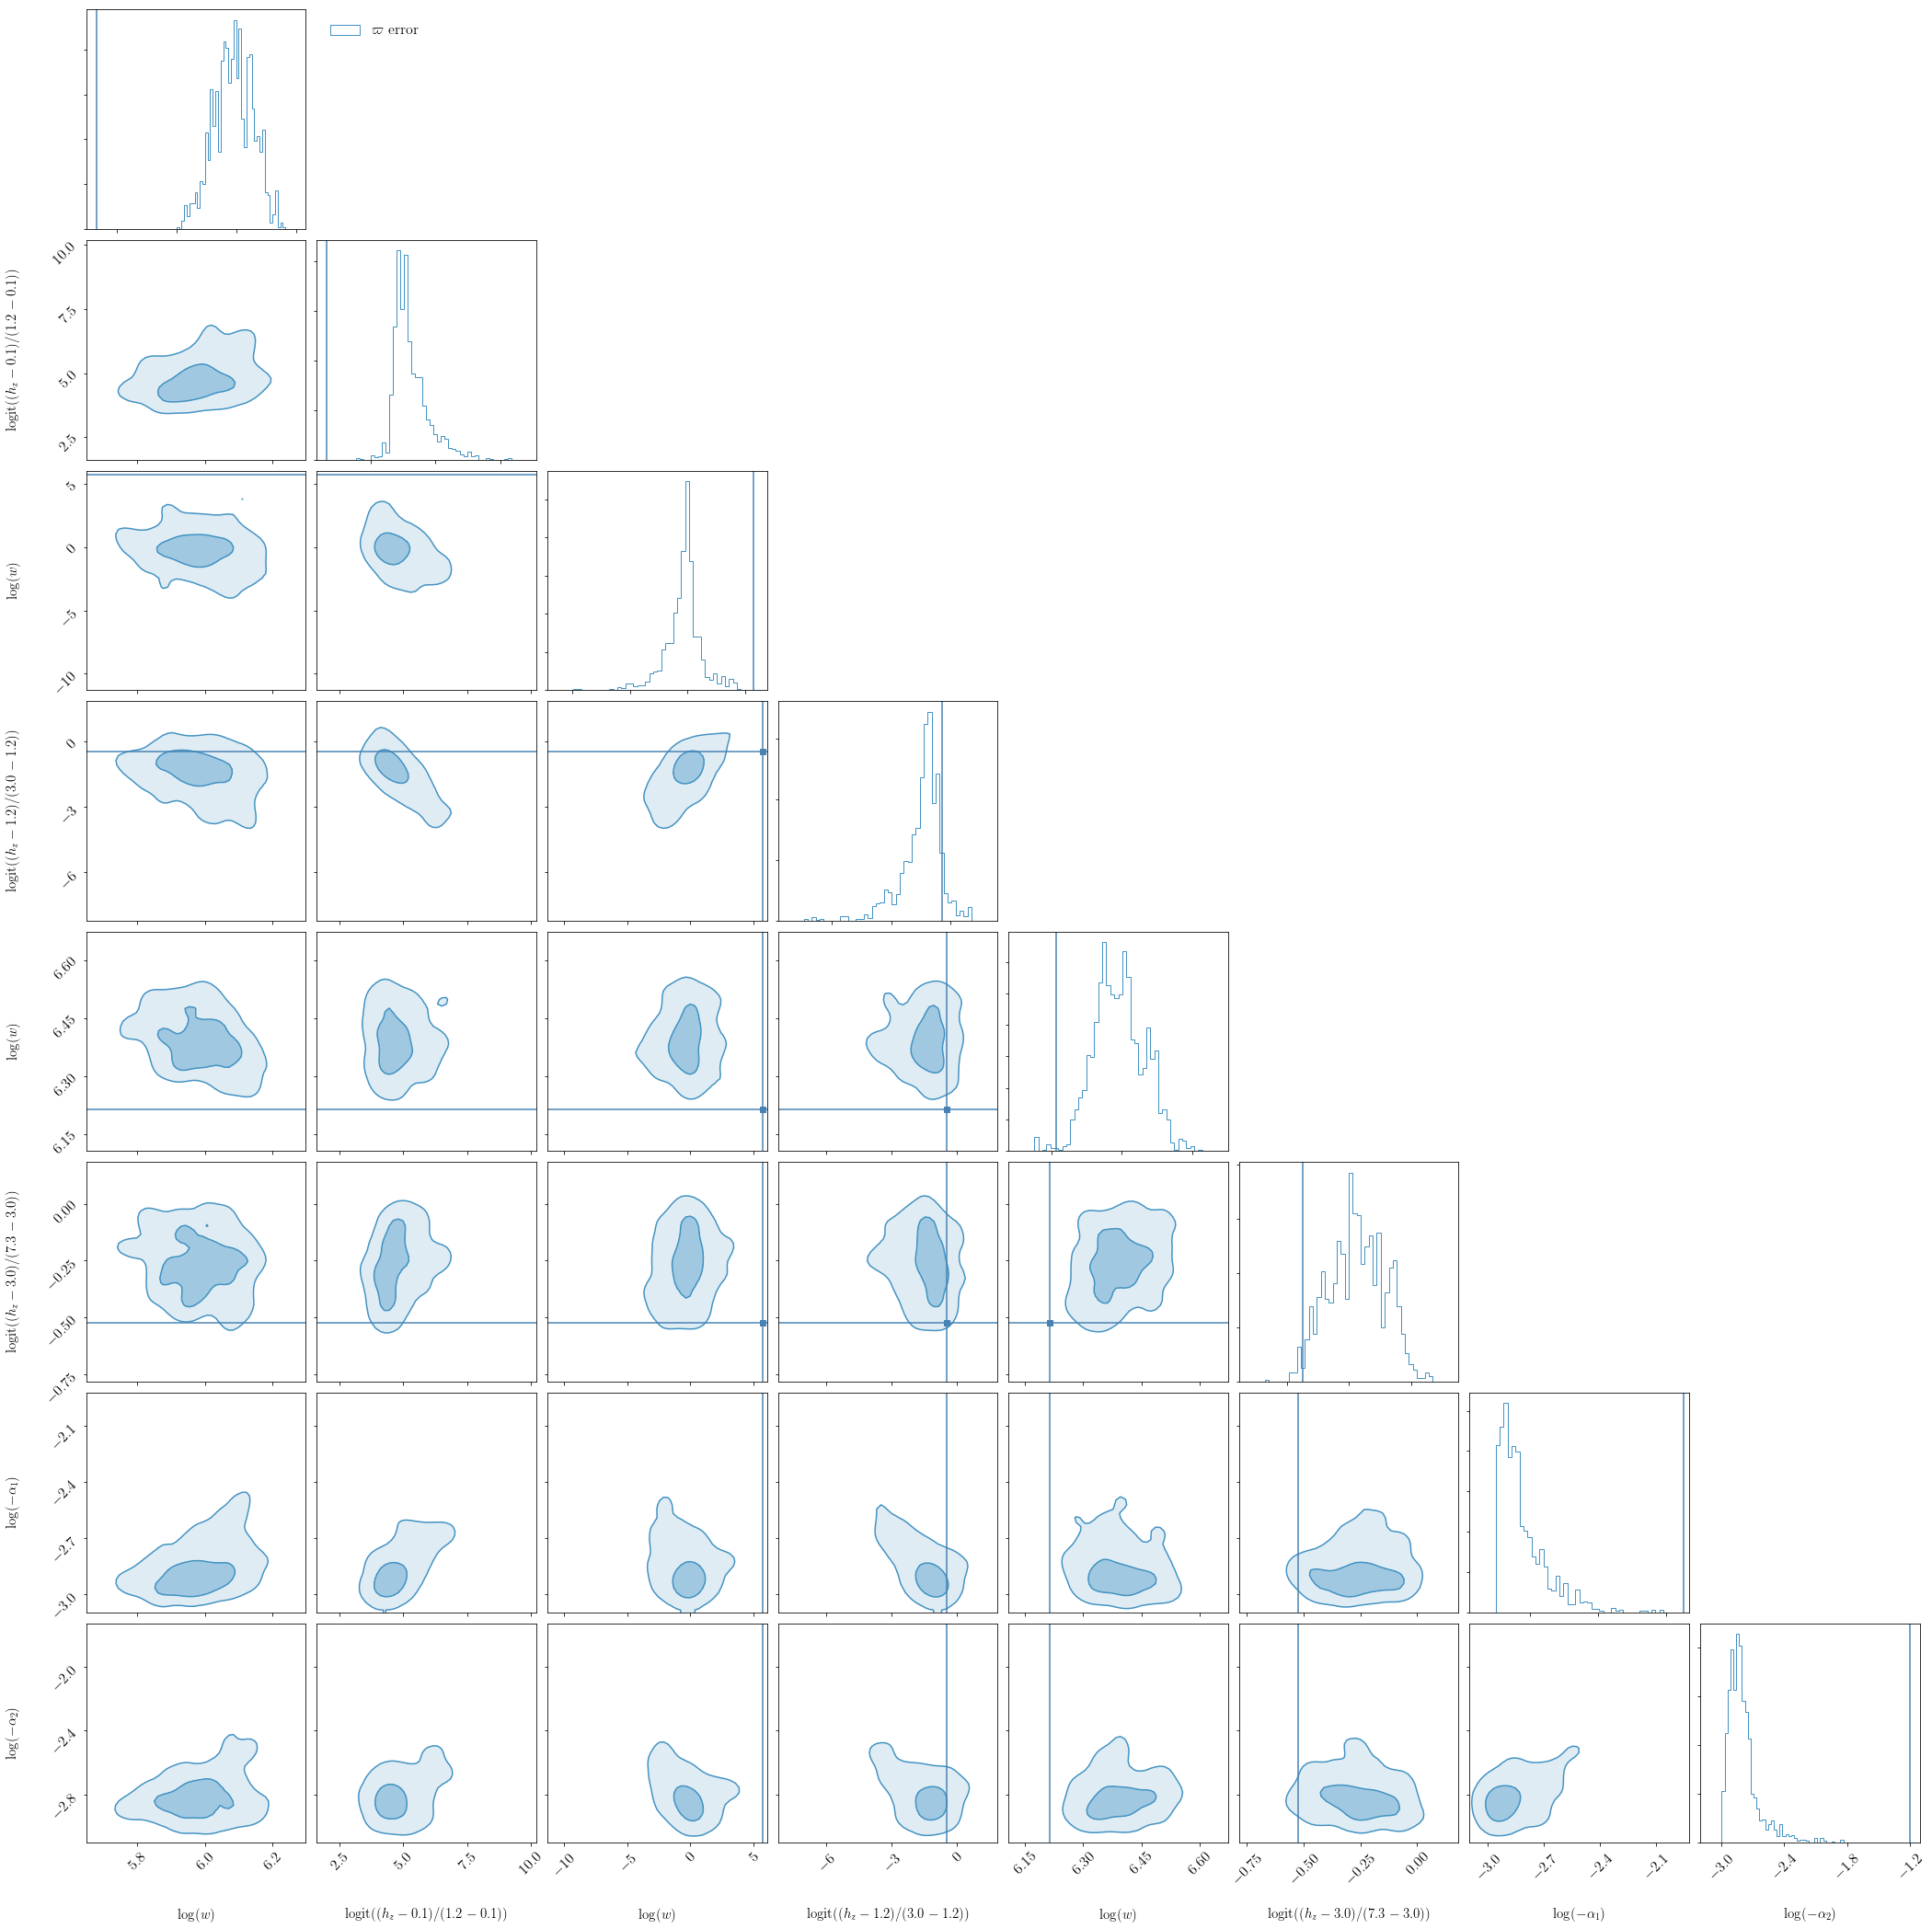

In [142]:
index = [r'$\varpi$ error']
ndim=len(true_params); fig, axes = plt.subplots(ndim,ndim, figsize=(30,30))
plotting.layered_corners([data['chain']['full_perr']], index=index, truths=true_params_f, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)], fig=fig, ax=axes)